In [1]:
library(tidyverse)
library(lubridate)
library(broom)
library(mltools)
library(rnoaa)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Registered S3 method overwritten by 'hoardr':
  method           from
  print.cache_info httr



In [2]:
WASHINGTON_STATION_ID <- "USC00186350"
LIESTAL_STATION_ID <- "GME00127786"
KYOTO_STATION_ID <- "JA000047759"
VANCOUVER_STATION_ID <- "CA001108395"

station_names <- list(
    "USC00186350" = "washingtondc",
    "GME00127786" = "liestal",
    "JA000047759" = "kyoto",
    "CA001108395" = "vancouver"
)

bloom_definition <- list(
    "washingtondc" = 0.70,
    "liestal" = 0.25,
    "kyoto" = 0.80,
    "vancouver" = 0.70
)

species <- list(
    "washingtondc" = "prunus_jamasakura",
    "liestal" = "prunus_avium",
    "kyoto" = "prunus_x_yedoensis",
    "vancouver" = "prunus_x_yedoensis"
)

washington_df <- read_csv("data/washingtondc.csv", show_col_types = FALSE)
liestal_df <- read_csv("data/liestal.csv", show_col_types = FALSE)
kyoto_df <- read_csv("data/kyoto.csv", show_col_types = FALSE)

df <- bind_rows(washington_df, liestal_df, kyoto_df)

In [3]:
df |> head()

location,lat,long,alt,year,bloom_date,bloom_doy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
washingtondc,38.88535,-77.03863,0,1921,1921-03-20,79
washingtondc,38.88535,-77.03863,0,1922,1922-04-07,97
washingtondc,38.88535,-77.03863,0,1923,1923-04-09,99
washingtondc,38.88535,-77.03863,0,1924,1924-04-13,104
washingtondc,38.88535,-77.03863,0,1925,1925-03-27,86
washingtondc,38.88535,-77.03863,0,1926,1926-04-11,101


In [4]:
data <- NULL

for (station in c(WASHINGTON_STATION_ID, LIESTAL_STATION_ID, KYOTO_STATION_ID))
{
    res <- ghcnd_search(
        stationid = station,
        var = c("TMAX", "PRCP"),
        date_min = "1950-01-01",
        date_max = "2021-12-31"
    )

    temp <- left_join(res$tmax, res$prcp, by = "date") |>
        select(date, tmax, prcp) |>
        mutate(
            year = year(date),
            month = month(date),
            year = ifelse(month > 3, year + 1, year),
            tmax = tmax / 10,
            tmax_delta = tmax - lag(tmax)
        ) |>
        group_by(year, month) |>
        summarize(
            tmax = mean(tmax, na.rm = TRUE),
            tmax_delta = mean(tmax_delta, na.rm = TRUE),
            prcp = mean(prcp, na.rm = TRUE)
        ) |>
        mutate(
            location = station_names[[station]],
            bloom_per = bloom_definition[[station_names[[station]]]],
            species = species[[station_names[[station]]]]
        )

    data_station <- inner_join(
        df,
        pivot_wider(
            temp,
            values_from = tmax:prcp,
            names_from = month
        ),
        by = c("location", "year")
    ) |>
        mutate(
            location = as.factor(location),
            species = as.factor(species)
        ) |>
        drop_na()

    if (is.data.frame(data)) {
        data <- bind_rows(data, data_station)
    } else {
        data <- data_station
    }
}

using cached file: ~/Library/Caches/R/noaa_ghcnd/USC00186350.dly

date created (size, mb): 2022-02-26 21:02:03 (2.693)

file min/max dates: 1948-08-01 / 2021-11-30

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.

using cached file: ~/Library/Caches/R/noaa_ghcnd/GME00127786.dly

date created (size, mb): 2022-02-26 21:02:06 (1.557)

file min/max dates: 1953-09-01 / 2022-01-31

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.

using cached file: ~/Library/Caches/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2022-02-26 21:02:08 (1.663)

file min/max dates: 1945-10-01 / 2022-02-28

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



In [5]:
splitSample <- sample(c("train", "test"), size=nrow(data), prob=c(0.70,0.30), replace = TRUE)
train <- data[splitSample=="train",]
test <- data[splitSample=="test",]

In [6]:
train |> head()

location,lat,long,alt,year,bloom_date,bloom_doy,bloom_per,species,tmax_1,⋯,prcp_3,prcp_4,prcp_5,prcp_6,prcp_7,prcp_8,prcp_9,prcp_10,prcp_11,prcp_12
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
washingtondc,38.88535,-77.03863,0,1952,1952-04-09,100,0.7,prunus_jamasakura,9.716129,⋯,37.44444,30.26667,23.35484,68.40000,26.225806,26.70968,25.700000,12.83871,35.33333,27.935484
washingtondc,38.88535,-77.03863,0,1955,1955-04-02,92,0.7,prunus_jamasakura,6.377419,⋯,31.45161,31.03333,34.92857,21.20000,19.580645,35.90323,6.100000,31.61290,17.30000,25.032258
washingtondc,38.88535,-77.03863,0,1956,1956-04-06,97,0.7,prunus_jamasakura,5.943333,⋯,32.82759,22.66667,21.61290,16.00000,7.551724,118.25806,6.933333,54.22581,13.20000,2.032258
washingtondc,38.88535,-77.03863,0,1958,1958-04-18,108,0.7,prunus_jamasakura,5.774194,⋯,62.22581,23.46667,17.48387,27.76667,4.741935,19.74194,34.433333,21.58065,22.40000,26.111111
washingtondc,38.88535,-77.03863,0,1959,1959-04-06,96,0.7,prunus_jamasakura,7.546667,⋯,20.54839,41.33333,26.48387,27.30000,61.774194,60.06452,21.266667,22.06452,19.56667,13.419355
washingtondc,38.88535,-77.03863,0,1960,1960-04-14,105,0.7,prunus_jamasakura,7.590323,⋯,15.96552,43.50000,27.51613,35.70000,33.709677,42.80645,10.000000,28.90323,20.60000,28.709677


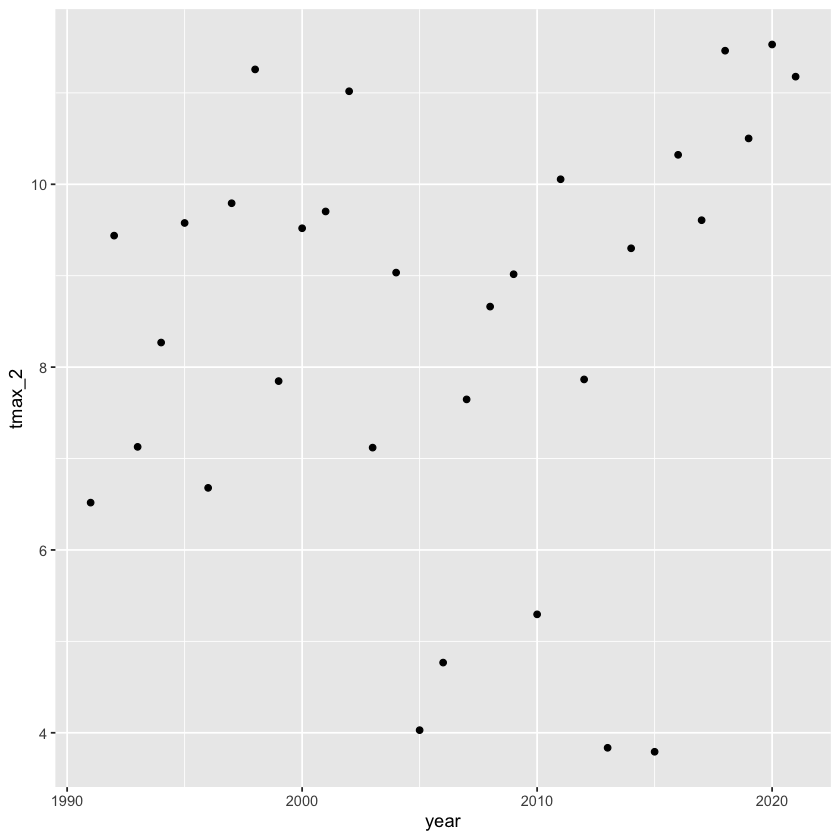

In [7]:
ggplot(train |> filter(year > 1990), aes(x = year, y = tmax_2)) +
    geom_point(stat = "summary", fun = mean)

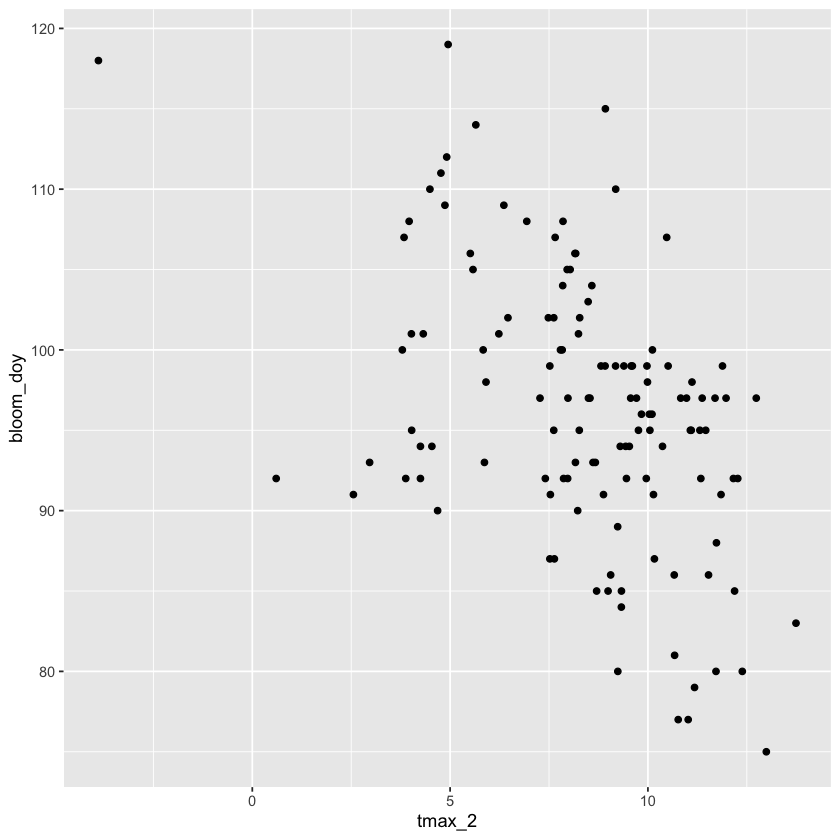

In [8]:
ggplot(train |> filter(year > 1950), aes(x = tmax_2, y = bloom_doy)) +
    geom_point()

In [9]:
bloom_lm <- train |>
    lm(formula = bloom_doy ~ species + tmax_2 + tmax_delta_2 + tmax_delta_1 + tmax_delta_12)

In [10]:
tidy(bloom_lm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),110.8909135,2.6493036,41.8566271,4.833359e-73
speciesprunus_avium,0.3356915,1.7219500,0.1949485,8.457657e-01
speciesprunus_x_yedoensis,7.3960579,1.6621743,4.4496284,1.948622e-05
tmax_2,-1.9868147,0.2701912,-7.3533645,2.684483e-11
tmax_delta_2,-1.0388348,2.5748427,-0.4034556,6.873371e-01
tmax_delta_1,5.6969011,3.9126338,1.4560272,1.480184e-01
tmax_delta_12,4.4683727,3.1375175,1.4241746,1.570129e-01


In [11]:
glance(bloom_lm)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.3749629,0.3434484,6.952691,11.89812,1.985553e-10,6,-419.5155,855.031,877.7213,5752.449,119,126


In [12]:
prediction <- bloom_lm |> predict(test)

In [13]:
mse(preds = prediction, actual = test$bloom_doy)

[1] 46.95694

In [14]:
rss <- sum((prediction - test$bloom_doy) ^ 2)  
tss <- sum((test$bloom_doy - mean(test$bloom_doy)) ^ 2)  
rsq <- 1 - rss/tss
rsq

[1] 0.2570716

In [17]:
pred_data <- NULL

for (station in c(WASHINGTON_STATION_ID, LIESTAL_STATION_ID, KYOTO_STATION_ID, VANCOUVER_STATION_ID))
{
    res <- ghcnd_search(
        stationid = station,
        var = c("TMAX", "PRCP"),
        date_min = "2021-04-01",
        date_max = "2022-02-28"
    )

    temp <- left_join(res$tmax, res$prcp, by = "date") |>
        select(date, tmax, prcp) |>
        mutate(
            year = year(date),
            month = month(date),
            year = ifelse(month > 3, year + 1, year),
            tmax = tmax / 10,
            tmax_delta = tmax - lag(tmax)
        ) |>
        group_by(year, month) |>
        summarize(
            tmax = mean(tmax, na.rm = TRUE),
            tmax_delta = mean(tmax_delta, na.rm = TRUE),
            prcp = mean(prcp, na.rm = TRUE)
        ) |>
        mutate(
            location = station_names[[station]],
            bloom_per = bloom_definition[[station_names[[station]]]],
            species = species[[station_names[[station]]]]
        )

    data_station <- pivot_wider(
            temp,
            values_from = tmax:prcp,
            names_from = month
        ) |>
        mutate(
            location = as.factor(location),
            species = as.factor(species)
        ) |>
        drop_na()

    if (is.data.frame(pred_data)) {
        pred_data <- bind_rows(pred_data, data_station)
    } else {
        pred_data <- data_station
    }
}

using cached file: ~/Library/Caches/R/noaa_ghcnd/USC00186350.dly

date created (size, mb): 2022-02-26 21:02:03 (2.693)

file min/max dates: 1948-08-01 / 2021-11-30

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.

using cached file: ~/Library/Caches/R/noaa_ghcnd/GME00127786.dly

date created (size, mb): 2022-02-26 21:02:06 (1.557)

file min/max dates: 1953-09-01 / 2022-01-31

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.

using cached file: ~/Library/Caches/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2022-02-26 21:02:08 (1.663)

file min/max dates: 1945-10-01 / 2022-02-28

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.

using cached file: ~/Library/Caches/R/noaa_ghcnd/CA001108395.dly

date created (size, mb): 2022-02-26 21:02:10 (1.281)

file min/max dates: 1957-01-01 / 2022-02-28

`summarise()` has grouped output by 'year'. You can override usi

In [18]:
pred_data

year,location,bloom_per,species,tmax_4,tmax_5,tmax_6,tmax_7,tmax_8,tmax_9,⋯,prcp_11,tmax_1,tmax_12,tmax_delta_1,tmax_delta_12,prcp_1,prcp_12,tmax_2,tmax_delta_2,prcp_2
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022,washingtondc,0.70,prunus_jamasakura,20.00000,24.81481,29.84333,32.60645,32.10968,28.50000,⋯,9.206897,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022,liestal,0.25,prunus_avium,15.06000,17.22581,26.22000,24.56129,23.50000,23.49333,⋯,15.800000,6.151613,6.764516,-0.2741935,0.3290323,12.51613,35.12903,NA,NA,NA
2022,kyoto,0.80,prunus_x_yedoensis,20.73333,24.80357,29.05517,32.93000,32.45667,28.71333,⋯,18.321429,8.222581,11.661290,0.1967742,-0.4967742,13.48387,30.38710,9.021739,-0.2181818,7.695652
2022,vancouver,0.70,prunus_x_yedoensis,13.74000,16.30000,22.42143,24.02581,23.04839,18.58667,⋯,104.133333,6.454839,3.967742,0.3064516,-0.4387097,47.51613,34.96667,7.254167,-0.1250000,9.956522


In [19]:
pred <- bloom_lm |> predict(pred_data)

In [20]:
pred

1         2         3         4 
       NA        NA  99.49033 103.78965